In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
sns.set_style('darkgrid')

from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModel, ElectraTokenizerFast

from data import SNLIBiEncoderBucketingDataset
from data.utils import get_data, collate_fn_buckets

from model import NLIBiEncoder

from training import Trainer

# Data

In [2]:
train, test, val = get_data('snli_1.0')

In [3]:
LABELS = ['entailment', 'contradiction', 'neutral']
NUM_LABELS = len(LABELS)

train = train[train.target.isin(set(LABELS))]
val = val[val.target.isin(set(LABELS))]
test = test[test.target.isin(set(LABELS))]

In [4]:
train.head()

,sentence1,sentence2,target
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [5]:
target2idx = {l: i for i, l in enumerate(LABELS)}
train.target = train.target.map(target2idx)
val.target = val.target.map(target2idx)
test.target = test.target.map(target2idx)

In [6]:
electra_tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')

In [7]:
train_dataset = SNLIBiEncoderBucketingDataset(electra_tokenizer, train.sentence1.tolist(), train.sentence2.tolist(), train.target.tolist(), batch_size=64)
val_dataset = SNLIBiEncoderBucketingDataset(electra_tokenizer, val.sentence1.tolist(), val.sentence2.tolist(), val.target.tolist(), batch_size=64)

100%|██████████| 19648/19648 [00:01<00:00, 10219.51it/s]


In [8]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn_buckets)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn_buckets)

# Model

In [9]:
electra = AutoModel.from_pretrained('google/electra-base-discriminator')

In [10]:
model = NLIBiEncoder(electra, NUM_LABELS, lambda x: x.last_hidden_state[:, 0, :])

In [11]:
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, criterion, 'electra/v2/electra_snli.pt', 'electra/v2/electra_optimizer.pt', lr=1e-4, device='cuda:0')

# Training

In [12]:
trainer.train(train_loader, val_loader, num_epochs=20, frozen_encoder_epochs=1)

Epoch 1/20:


Mean loss: 1.012581503391266. Current progress: : 100%|██████████| 8584/8584 [11:40<00:00, 12.25it/s] 


Mean training loss: 1.0265294301765384. Mean validation loss: 0.9512120593677867.
Training accuracy: 0.4713588548274651. Validation accuracy: 0.5495724755700325.
Epoch 2/20:


Mean loss: 0.632846189558506. Current progress: : 100%|██████████| 8584/8584 [37:32<00:00,  3.81it/s] 


Mean training loss: 0.7109824178943485. Mean validation loss: 0.5783554956123427.
Training accuracy: 0.6945866788503859. Validation accuracy: 0.7636400651465798.
Epoch 3/20:


Mean loss: 0.5618651313781738. Current progress: : 100%|██████████| 8584/8584 [37:21<00:00,  3.83it/s]


Mean training loss: 0.5813640469593193. Mean validation loss: 0.5149572650333504.
Training accuracy: 0.7649076118514582. Validation accuracy: 0.7961115635179153.
Epoch 4/20:


Mean loss: 0.5089586823582649. Current progress: : 100%|██████████| 8584/8584 [36:53<00:00,  3.88it/s]


Mean training loss: 0.5215642973433448. Mean validation loss: 0.4948361733710611.
Training accuracy: 0.7930581924287408. Validation accuracy: 0.8048656351791531.
Epoch 5/20:


Mean loss: 0.47389267256855966. Current progress: : 100%|██████████| 8584/8584 [36:20<00:00,  3.94it/s]


Mean training loss: 0.4790117660726578. Mean validation loss: 0.4897056571268416.
Training accuracy: 0.8130302693827623. Validation accuracy: 0.8130089576547231.
Epoch 6/20:


Mean loss: 0.45025786811113355. Current progress: : 100%|██████████| 8584/8584 [36:22<00:00,  3.93it/s]


Mean training loss: 0.44457413040740346. Mean validation loss: 0.4913806016375492.
Training accuracy: 0.82871741477009. Validation accuracy: 0.8128053745928339.
Epoch 7/20:


Mean loss: 0.41598940336704254. Current progress: : 100%|██████████| 8584/8584 [36:26<00:00,  3.93it/s]


Mean training loss: 0.41153314478785663. Mean validation loss: 0.4957225688479163.
Training accuracy: 0.8432049977519581. Validation accuracy: 0.8129071661237784.
Epoch 8/20:


Mean loss: 0.3926585331708193. Current progress: :  84%|████████▎ | 7189/8584 [30:28<06:00,  3.87it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Mean loss: 0.35110019156336786. Current progress: :  20%|██        | 1736/8584 [07:23<29:15,  3.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Mean loss: 0.35932619255781173. Current progress: :  55%|█████▌    | 4748/8584 [20:08<15:44,  4.06it/s]IOPub message rate exceeded.
The notebook

Mean training loss: 0.331321650655994. Mean validation loss: 0.5638584613606528.
Training accuracy: 0.8761247035224177. Validation accuracy: 0.813314332247557.
Epoch 11/20:


Mean loss: 0.3118524910956621. Current progress: : 100%|██████████| 8584/8584 [36:25<00:00,  3.93it/s] 


Mean training loss: 0.3089174063557729. Mean validation loss: 0.5814881782446589.
Training accuracy: 0.8856010644978676. Validation accuracy: 0.8132125407166124.
Epoch 12/20:


Mean loss: 0.2919294434785843. Current progress: : 100%|██████████| 8584/8584 [36:24<00:00,  3.93it/s] 


Mean training loss: 0.28941578574943855. Mean validation loss: 0.5999602543843257.
Training accuracy: 0.893404591102123. Validation accuracy: 0.8183021172638436.
Epoch 13/20:


Mean loss: 0.2753620317578316. Current progress: : 100%|██████████| 8584/8584 [36:16<00:00,  3.94it/s] 


Mean training loss: 0.2692911618837057. Mean validation loss: 0.627264773400573.
Training accuracy: 0.9012245001975. Validation accuracy: 0.8161644951140065.
Epoch 14/20:


Mean loss: 0.26143043193221094. Current progress: : 100%|██████████| 8584/8584 [36:11<00:00,  3.95it/s]


Mean training loss: 0.2537286093758848. Mean validation loss: 0.7042708626234686.
Training accuracy: 0.9074189021182562. Validation accuracy: 0.8147394136807817.
Epoch 15/20:


Mean loss: 0.2464216263368726. Current progress: : 100%|██████████| 8584/8584 [36:12<00:00,  3.95it/s] 


Mean training loss: 0.2369396341665156. Mean validation loss: 0.6973035376180302.
Training accuracy: 0.9138353778075494. Validation accuracy: 0.8135179153094463.
Epoch 16/20:


Mean loss: 0.23372598844021558. Current progress: : 100%|██████████| 8584/8584 [36:13<00:00,  3.95it/s]


Mean training loss: 0.22354915063764869. Mean validation loss: 0.7131930247142717.
Training accuracy: 0.9189357933767409. Validation accuracy: 0.8143322475570033.
Epoch 17/20:


Mean loss: 0.21931248732656242. Current progress: : 100%|██████████| 8584/8584 [36:36<00:00,  3.91it/s]


Mean training loss: 0.21084994165802276. Mean validation loss: 0.7803511228654292.
Training accuracy: 0.9241800108124442. Validation accuracy: 0.8101587947882736.
Validation performance has started degrading. Performing early stopping.


NLIBiEncoder(
  (encoder): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

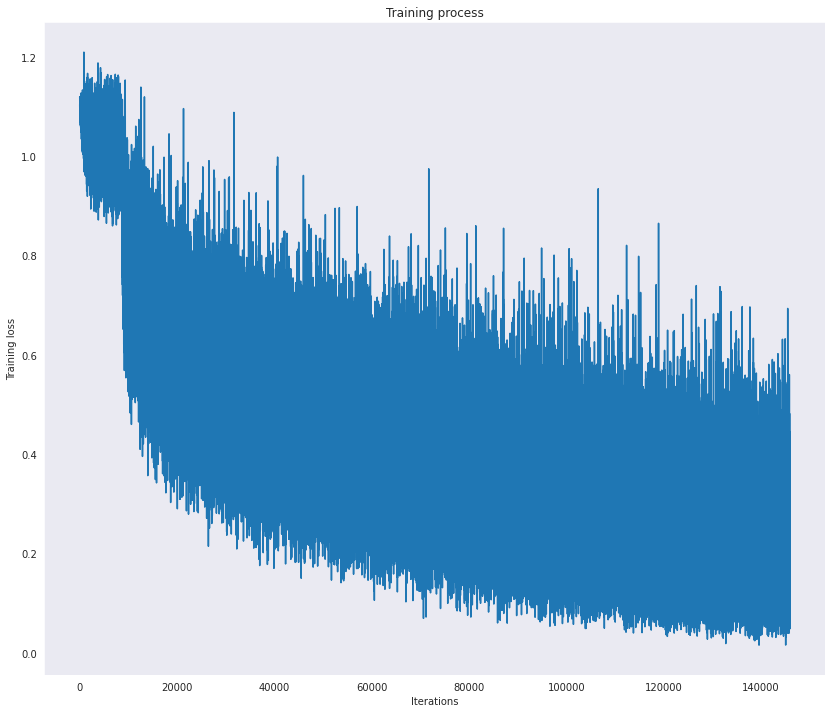

In [13]:
plt.figure(figsize=(14, 12))
plt.plot(trainer.train_losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Training loss');